# Предсказание временных рядов

## Библиотеки

In [71]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import gridspec

from tqdm.notebook import tqdm
import numpy as np
import  pandas as pd
import seaborn as sns
import torch
import scipy
import json
import sys
import re
import os

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

from sklearn.cluster import AgglomerativeClustering

from sklearn.manifold import MDS

from sklearn.decomposition import PCA

from mpl_toolkits.mplot3d import Axes3D

import scipy as sp

import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from scipy.special import softmax

import pandas as pd

from sklearn.preprocessing import scale

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.decomposition import PCA

from scipy.interpolate import interp1d

import math

import scipy.stats as st

from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA

from statsmodels.stats.diagnostic import acorr_ljungbox

from statsmodels.tsa.holtwinters import ExponentialSmoothing


### Вспомагательные функции

In [72]:
def RandomFunction(x, n=2):
    N = np.arange(1, n + 1, 1)
    A = np.random.randn(n)
    B = np.random.randn(n)
    A0 = np.random.randn(1)
    
    y = 0.5*np.ones_like(x)*A0
    
    for n, a, b in zip(N, A, B):
        y += a*np.sin(n*x) + b*np.cos(n*x)
    
    return y

def GenerateImpulses(n = 20, T = 2, k = 2, function = np.sin):
    
    t = int(T)//2
    
    x = np.linspace(start = 0, stop = T*np.pi, num = n)
    
    List_y = []
    
    for i in range(k):
        y_temp = 5*np.random.randn()*function(x + np.random.rand()*2*np.pi)
        List_y.append(y_temp)
    
    y = np.array(List_y[0])
    
    y2 = List_y[np.random.randint(0, k)]
    
    for i in range(0, t):
        if np.random.rand() < 0.1:
            y2 = List_y[np.random.randint(0, k)]
        
        ind = np.where(x <= 2*(i + 1)*np.pi)
        ind = np.where(x[ind] > 2*i*np.pi)
        y[ind] = y2[ind]
        
    return y
    

def GeneratorOfTimeSeries(n = 100, m = 16384, k = 20):
    T1 = []
    T2 = []
    T3 = []
    for _ in range(m):
        numPi = 80 + np.random.randint(0, 20)
        numPi = n//k
        function = np.sin
        if np.random.rand() < -4*0.5:
            function = RandomFunction
            
        series = GenerateImpulses(n = n, T = numPi, k = np.random.randint(K, K+1), function=function)
        T1.append(series + 0.5*np.random.randn(n))
    T1 = np.asarray(T1)
    
    return np.reshape(T1, [T1.shape[0], T1.shape[1], 1])

  

def return_h(input, i, l = 10):
    return np.sum(input[:, i:i+l, :], axis = -1)

def return_phase_track(input, l = 10):
    """
    input has a shape [batch_size, time_len, 1]
    """

    phase_track = np.zeros([input.shape[0], input.shape[1] - l, l])
    
    for i in range(0, input.shape[1] - l):
        phase_track[:, i, :] = return_h(input, i, l)
    
    return phase_track[0]
    

def local_basis(phase_track, m = 2, T = 20):

    result_pca_1 = phase_track

    List_of_basis_vector = []
    List_of_basis_vector_s = []
    List_of_basis_vector_c = []

    model_pca = PCA(n_components=2)

    for n in range(T, result_pca_1.shape[0] - T, 1):
        if n-T >- 0:
            arr = result_pca_1[n-T:n+T]
        else:
            arr = result_pca_1[:n]
        
        model_pca_answ = model_pca.fit_transform(arr)
        
        List_of_basis_vector_s.append(model_pca.singular_values_)
        
        List_of_basis_vector_c.append(model_pca_answ[-1])
        List_of_basis_vector.append(model_pca.components_)

    List_of_basis_vector = np.array(List_of_basis_vector)
    List_of_basis_vector_s = np.array(List_of_basis_vector_s)
    List_of_basis_vector_c = np.array(List_of_basis_vector_c)

    return List_of_basis_vector, List_of_basis_vector_s, List_of_basis_vector_c
 

def get_pairwise_matrix(List_of_basis_vector, List_of_basis_vector_s, List_of_basis_vector_c):

    Volum = np.zeros([2, List_of_basis_vector.shape[0], List_of_basis_vector.shape[0]])

    cos_beta = np.abs(List_of_basis_vector[:, 0, :]@List_of_basis_vector[:, 1, :].T)
    cos_alpha = np.array(np.diagonal(cos_beta))
    cos_gamma = np.abs(List_of_basis_vector[:, 1, :]@List_of_basis_vector[:, 1, :].T)

    cos_beta[np.where(cos_beta > 1-10**(-10))] = 1-10**(-10)
    cos_alpha[np.where(cos_alpha > 1-10**(-10))] = 1-10**(-10)
    cos_gamma[np.where(cos_gamma > 1-10**(-10))] = 1-10**(-10)

    cos_beta[np.where(cos_beta < 10**(-10))] = 0
    cos_alpha[np.where(cos_alpha < 10**(-10))] = 0
    cos_gamma[np.where(cos_gamma < 10**(-10))] = 0


    temp_a = np.sqrt(1-cos_beta**2)
    cos_A = np.abs((cos_alpha.reshape([-1,1]) - cos_gamma*cos_beta)/(np.sqrt(1-cos_gamma**2)*np.sqrt(1-cos_beta**2)))
    h = temp_a*np.sqrt(1-cos_A**2)

    Volum[0] = h* np.sqrt(1-cos_gamma**2)
        
    cos_beta = np.abs(List_of_basis_vector[:, 0, :]@List_of_basis_vector[:, 0, :].T)
    cos_gamma = np.abs(List_of_basis_vector[:, 1, :]@List_of_basis_vector[:, 0, :].T)

    cos_alpha = np.array(np.diagonal(cos_gamma))

    cos_beta[np.where(cos_beta > 1-10**(-10))] = 1-10**(-10)
    cos_alpha[np.where(cos_alpha > 1-10**(-10))] = 1-10**(-10)
    cos_gamma[np.where(cos_gamma > 1-10**(-10))] = 1-10**(-10)


    cos_beta[np.where(cos_beta < 10**(-10))] = 0
    cos_alpha[np.where(cos_alpha < 10**(-10))] = 0
    cos_gamma[np.where(cos_gamma < 10**(-10))] = 0


    temp_a = np.sqrt(1-cos_beta**2)
    cos_A = (cos_alpha.reshape([-1,1]) - cos_gamma*cos_beta)/(np.sqrt(1-cos_gamma**2)*np.sqrt(1-cos_beta**2))
    h = temp_a*np.sqrt(1-cos_A**2)

    Volum[1] = h* np.sqrt(1-cos_gamma**2)
          
    vol = np.max(Volum, axis = 0)

    for i in range(vol.shape[0]):
        for j in range(vol.shape[0]):
            vol[i,j] = max(vol[i,j], vol[j,i])  

    dist = np.sqrt((List_of_basis_vector_s[:, :1] - List_of_basis_vector_s[:, :1].T)**2 + (List_of_basis_vector_s[:, 1:2] - List_of_basis_vector_s[:, 1:2].T)**2)
    dist = dist/np.max(dist)

    full_dist = np.sqrt(vol**2+dist**2)

    return full_dist


def find_points(points, line_point):
    """
    points have a shape [N x 2]
    line_point has a shape [2 x 1]
    """
    List_of_points_plus = []
    List_of_points_minus = []
    
    List_of_t_plus = []
    List_of_t_minus = []
    
    for i in range(len(points) - 1):
        if (line_point[1]*points[i][0] - line_point[0]*points[i][1] < 0) and(line_point[1]*points[i+1][0] - line_point[0]*points[i+1][1] > 0):
            List_of_points_plus.append(points[i])
            List_of_t_plus.append(i)
        if (line_point[1]*points[i][0] - line_point[0]*points[i][1] > 0) and(line_point[1]*points[i+1][0] - line_point[0]*points[i+1][1] < 0):
            List_of_points_minus.append(points[i])
            List_of_t_minus.append(i)
    
    return np.array(List_of_points_plus), np.array(List_of_points_minus), np.array(List_of_t_plus), np.array(List_of_t_minus)

def find_distance(points, line_point):
    """
    points have a shape [N x 2]
    line_point has a shape [2 x 1]
    """
    
    sum_distance = 0
    
    normal = np.array([line_point[1], -line_point[0]])
    normal = normal/np.sqrt((normal*normal).sum())
    
    for p in points:
        sum_distance += ((normal*p).sum())
    
    
    return sum_distance

def find_segment(X, T):
    phase_track = return_phase_track(X, T)
    model = PCA(n_components=2)

    ress = model.fit_transform(phase_track)
    
    ress[:, 0] = ress[:, 0]/np.sqrt(((ress[:, 0]**2).mean()))

    ress[:, 1] = ress[:, 1]/np.sqrt(((ress[:, 1]**2).mean()))

    Phi = np.linspace(-np.pi, np.pi, 200)

    All_List = np.array(list(map(lambda phi: find_points(ress, np.array([np.sin(phi), np.cos(phi)])), Phi)))

    List_of_std = []
    for l, phi in zip(All_List, Phi):
        List_of_std.append(find_distance(np.vstack([l[0], l[1]]), np.array([np.sin(phi), np.cos(phi)])))

    List_of_std = np.array(List_of_std)
    
    phi = Phi[np.argmin(List_of_std)]
    
    
    line_point = np.array([np.sin(phi), np.cos(phi)])

    List_of_points_plus, List_of_points_minus, List_of_t_plus, List_of_t_minus = find_points(ress, line_point)
    
    return List_of_points_plus, List_of_points_minus, List_of_t_plus, List_of_t_minus, line_point, ress
    
    
def segmentation(X_all, prediction_vector, T):
    List_of_point = []
    List_of_All = []
    for t in np.unique(prediction_vector):
        ind = np.where(prediction_vector == t)[0]

        X = X_all[:, ind, :]
        List_of_t = np.arange(0, X.shape[1], 1)

        List_of_points_plus, List_of_points_minus, List_of_t_plus, List_of_t_minus, line_point, ress = find_segment(X, T)

        List_of_All.append([X, List_of_t, List_of_points_plus, List_of_points_minus, List_of_t_plus, List_of_t_minus, line_point, ress])
        List_of_point.append((np.where(prediction_vector == t)[0])[List_of_t_minus])

    return List_of_All, List_of_point

def normalizer(x, t, n = None):
    if n == None:
        t_new = np.arange(np.min(t), np.max(t), 0.01)
    else:
        t_new = np.linspace(np.min(t), np.max(t), n, endpoint=True)
    
    f = interp1d(t, x, kind='cubic')
    
    return f(t_new)

def sort_prediction(prediction_vector):
    prediction_vector += 1000
    iterator = 0

    need = np.where(prediction_vector >= 1000)[0]
    while len(need) > 0:
        prediction_vector[np.where(prediction_vector == prediction_vector[need[0]])] = iterator
        iterator += 1
        need = np.where(prediction_vector >= 1000)[0]
        
    return prediction_vector

## Авторегрессия

Задан временной ряд:
$$
\mathbf{y} = [y_0, y_i, \cdots, y_t],
$$
где $t$ число известных точек временного ряда.

Требуется построить предсказательную модель:
$$
\hat{y}_{t+d} = f_{t, d}\bigr(\mathbf{y}, \mathbf{w}\bigr)
$$

Самое простое решение это линейная модель авторегрессии:
$$
\hat{y}_{t+1}\bigr(w\bigr) = \sum_{j=0}^{n-1}w_jy_{t-j}
$$

В чем плюсы? Легко решать! Простая задача линейной регрессии, а имено в качестве признакового описания:
$$
\mathbf{X} = \begin{bmatrix}
y_{t-1} & \cdots & y_{t-n}\\
\cdots & \cdots & \cdots\\
y_{n-1} & \cdots & y_{0}\\
\end{bmatrix}
$$

В качестве целевой переменной:
$$
\mathbf{y} = \begin{bmatrix}
y_{t}\\
\cdots\\
y_{n}\\
\end{bmatrix}
$$

Классичиская задача оптимизации:
$$
||\mathbf{X}\mathbf{w} - \mathbf{y}|| \to \min_{\mathbf{w}}
$$

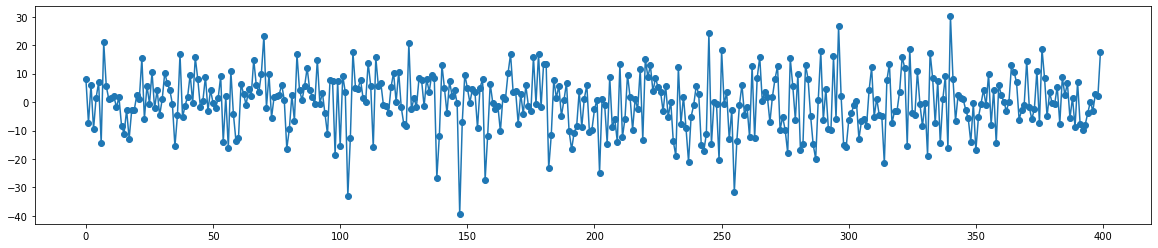

In [73]:
fig = plt.figure(figsize=(20,4))

np.random.seed(0)
points = np.arange(400)
series = RandomFunction(points, n=100)
plt.plot(series, '-o')
plt.show()

In [74]:
n = 100

X = np.zeros(shape=(len(series)-n, n))
y = np.zeros(shape=(len(series)-n, 1))

y = series[n:len(series)]
for j in range(len(series)-n):
    X[j] = series[j:j+n]

X_train = X[:-100]
y_train = y[:-100]
X_test = X[-100:]
y_test = y[-100:]

w = np.linalg.inv(X_train.T@X_train)@X_train.T@y_train

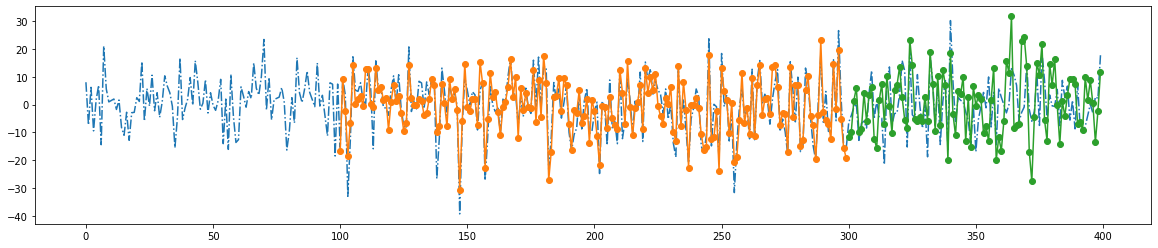

In [75]:
fig = plt.figure(figsize=(20,4))
plt.plot(points, series, '-.')
plt.plot(points[n:len(series)-100], X_train@w, '-o')
plt.plot(points[-100:], X_test@w, '-o')
plt.show()

#### Эксперимент по изменению $n$

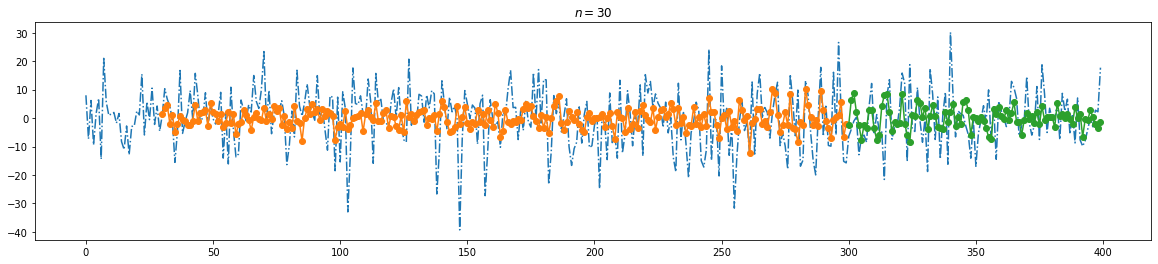

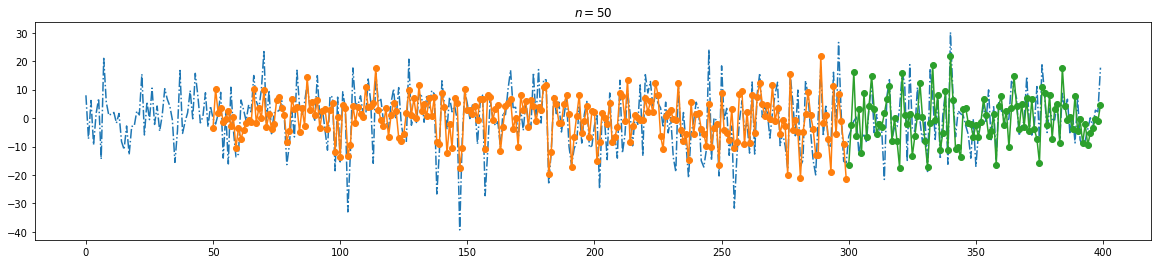

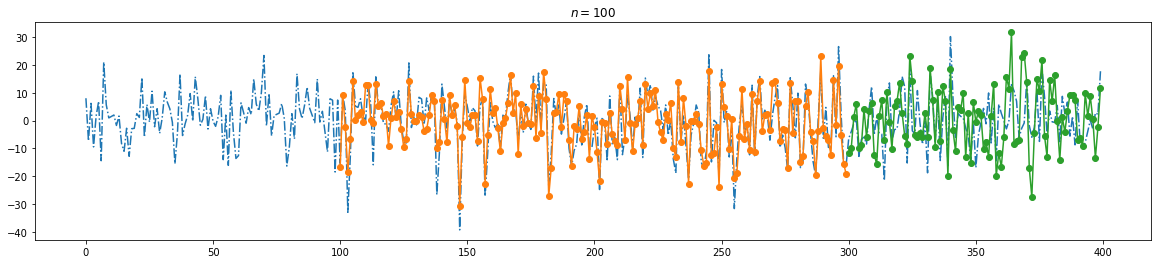

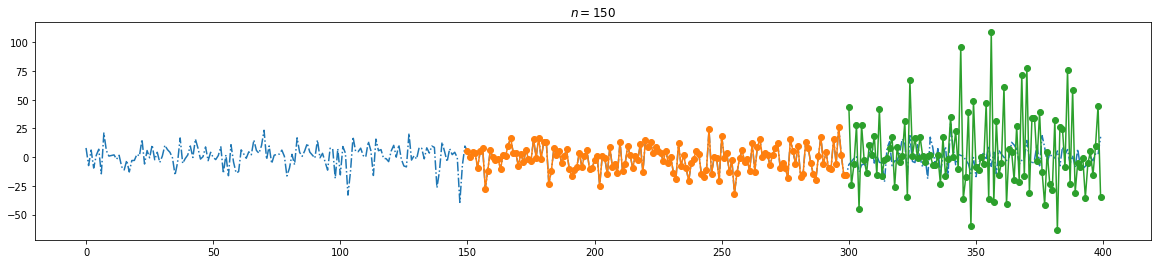

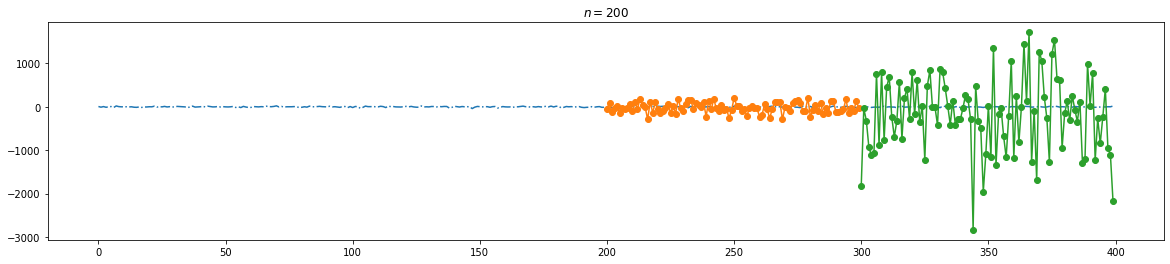

In [76]:
for n in [30, 50, 100, 150, 200]:
    X = np.zeros(shape=(len(series)-n, n))
    y = np.zeros(shape=(len(series)-n, 1))

    y = series[n:len(series)]
    for j in range(len(series)-n):
        X[j] = series[j:j+n]

    X_train = X[:-100]
    y_train = y[:-100]
    X_test = X[-100:]
    y_test = y[-100:]

    w = np.linalg.inv(X_train.T@X_train)@X_train.T@y_train

    fig = plt.figure(figsize=(20,4))
    plt.plot(points, series, '-.')
    plt.plot(points[n:len(series)-100], X_train@w, '-o')
    plt.plot(points[-100:], X_test@w, '-o')
    plt.title('$n={}$'.format(n))
    plt.show()

Хм, почему так? Ответ - мультиколлинеарность!

## Экспоненциальное среднее

Модель:
$$
\hat{y}_{t+1} = \hat{y}_{t} + \alpha_t\left(y_t - \hat{y}_t\right).
$$

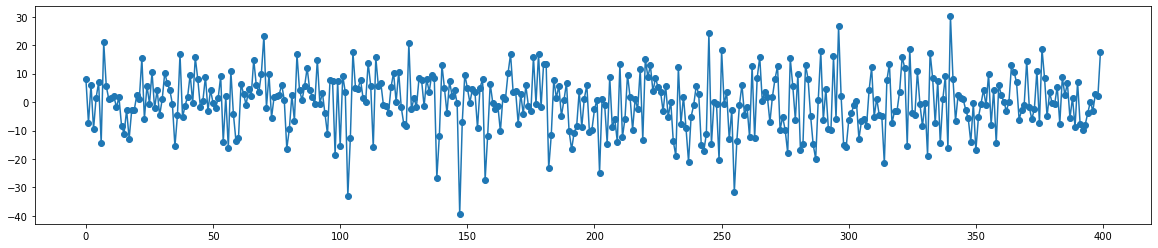

In [77]:
np.random.seed(0)
points = np.arange(400)
series = RandomFunction(points, n=100)

fig = plt.figure(figsize=(20,4))
plt.plot(series, '-o')
plt.show()

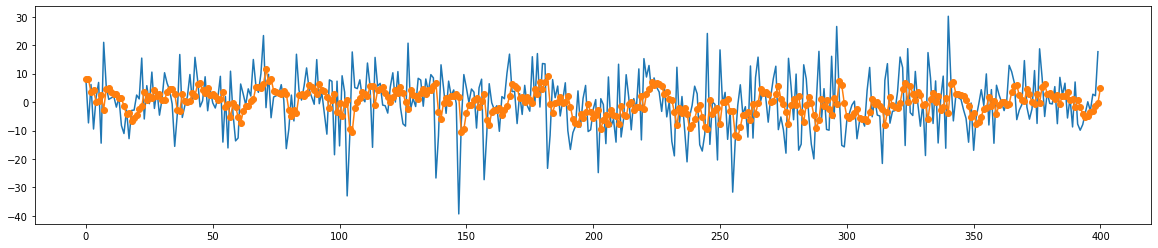

In [78]:
series_hat = [series[0]]
alpha = 0.3
for t in range(len(series)):
    series_hat.append(series_hat[t] + alpha*(series[t]- series_hat[t]))

fig = plt.figure(figsize=(20,4))
plt.plot(series, '-')
plt.plot(series_hat, '-o')
plt.show()

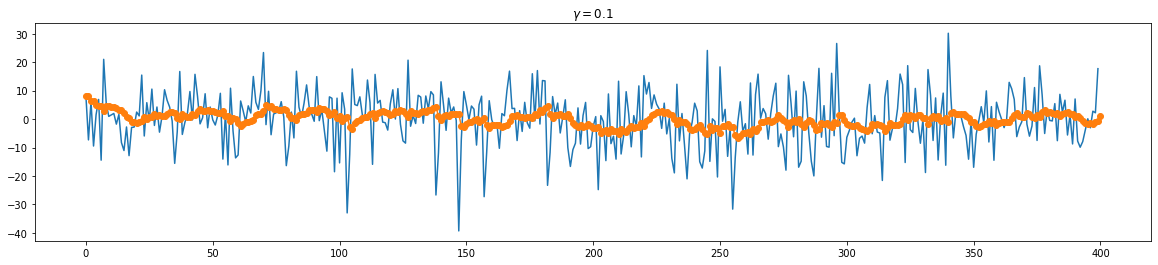

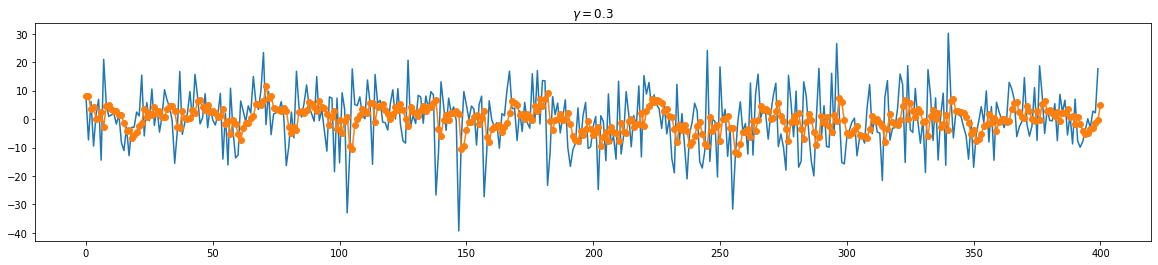

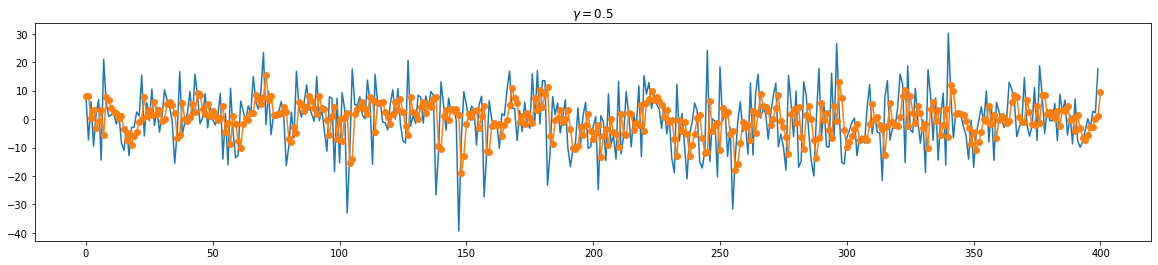

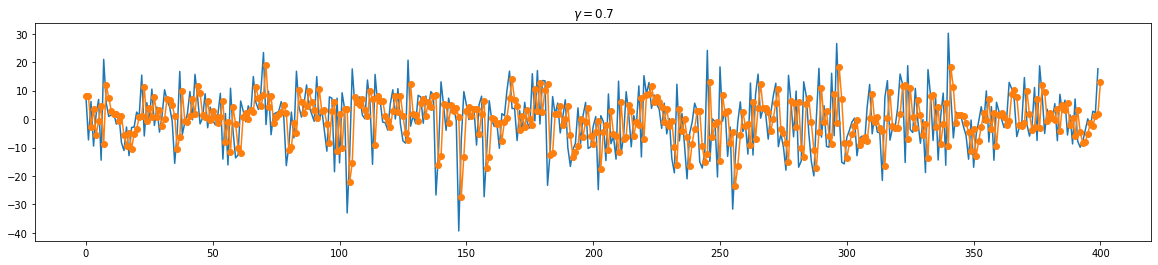

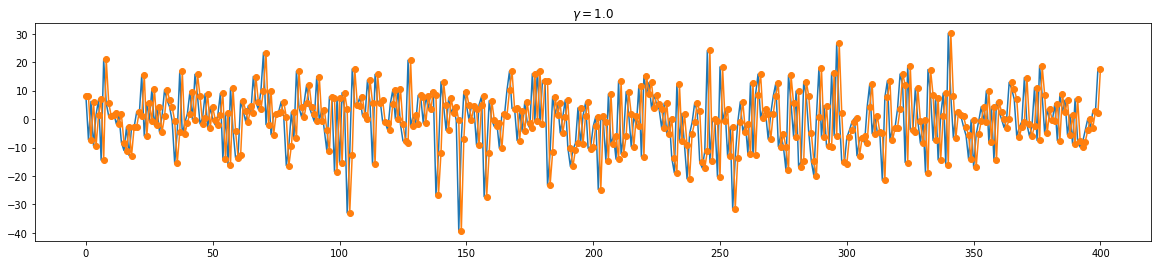

In [79]:
for alpha in [0.1, 0.3, 0.5, 0.7, 1.0]:
    series_hat = [series[0]]
    for t in range(len(series)):
        series_hat.append(series_hat[t] + alpha*(series[t]- series_hat[t]))
    
    fig = plt.figure(figsize=(20,4))
    plt.plot(series, '-')
    plt.plot(series_hat, '-o')
    plt.title('$\gamma={}$'.format(alpha))
    plt.show()

## Немного из лекции по прикладных статах
[Полная версия тут.](https://github.com/Intelligent-Systems-Phystech/psad/blob/master/seminars/sem9/main.ipynb)

In [80]:
data = pd.read_csv(
    'https://raw.githubusercontent.com/Intelligent-Systems-Phystech/psad/master/seminars/sem9/data/time.txt', parse_dates=[0], dayfirst=True)

In [81]:
data.head()

,Time
0,2019-02-10
1,2019-02-10
2,2019-02-12
3,2019-02-12
4,2019-02-13


In [82]:
groups = data['Time'].groupby(data['Time']).count()
data = groups.cumsum()

### ARIMA

In [83]:
new_data = {}
time_iter = pd.date_range('20190210','20190401',freq='D')
old_data = None
for i in time_iter:
    if i in data:
        new_data[i] = float(data[i])
        old_data = new_data[i] 
    else:
        new_data[i] = old_data

new_data = pd.DataFrame({'Time':new_data})

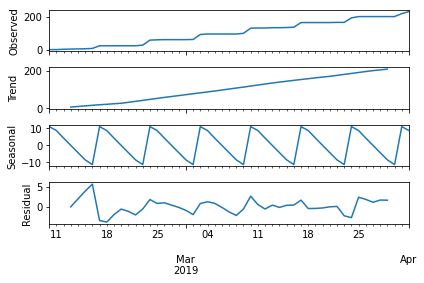

In [84]:
stl_data = seasonal_decompose(new_data['Time'])
stl_data.plot()

plt.show()

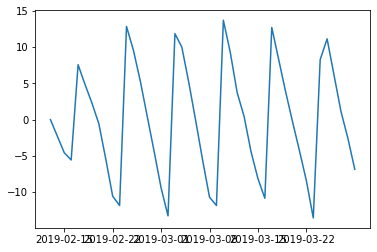

In [85]:
new_data_without_trend = new_data.copy()[3:-3]
new_data_without_trend['Time'] = (new_data['Time'] - stl_data.trend)[3:-3]
plt.plot(new_data_without_trend)

plt.show()

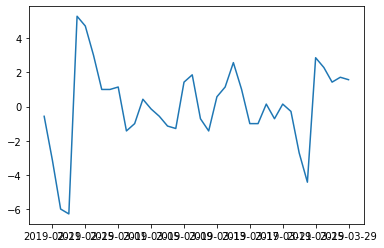

In [86]:
plt.plot(new_data_without_trend.diff(7))

plt.show()

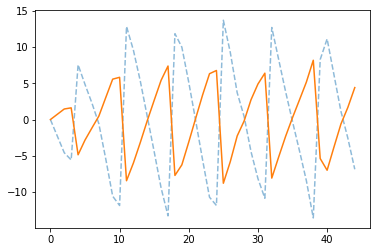

In [87]:
arima = ARIMA(new_data_without_trend['Time'].values, order=(1,1,1)).fit()

plt.plot(new_data_without_trend['Time'].values, alpha=0.5, ls='--')
plt.plot(arima.predict(1, len(new_data_without_trend), dynamic=False))

plt.show()

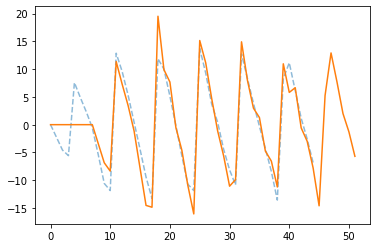

In [88]:
arima = SARIMAX(new_data_without_trend['Time'].values, order=(1,0,1), seasonal_order=(0,2,1,7)).fit()

plt.plot(new_data_without_trend['Time'].values, alpha=0.5, ls='--')
plt.plot(arima.predict(0, len(new_data['Time'].values)))

plt.show()

## Кластеризация временных рядов
**Grabovoy A.V., Strijov V.V. Quasi-periodic time series clustering for human activity recognition // Lobachevskii Journal of Mathematics, 2020, 41 : 333-339**

Задан временной ряд
$$
\textbf{x} \in \mathbb{R}^{N},
$$
где $N$ число точек временного ряда. Он состоит из последовательности сегментов:
$$
\textbf{x} = [\textbf{v}_1, \textbf{v}_2, \cdots, \textbf{v}_M],
$$
где $\textbf{v}_i$ некоторый сегмент из множества сегментов $\mathbf{V},$ которые встречаются в данном ряде.

Причем для всех $i$ либо $[\textbf{v}_{i-1},\textbf{v}_{i}]$ либо $[\textbf{v}_{i},\textbf{v}_{i+1}]$  является цепочкой действий. Пусть множество $\mathbf{V}$ удовлетворяет следующим свойствам:

$$
\left|\mathbf{V}\right| = K, \quad \textbf{v} \in \mathbf{V}~\left|\textbf{v}\right| \leq T,
$$
где $\left|\mathbf{V}\right|$ число различных действий в множестве сегментов $\mathbf{V},$ $\left|\textbf{v}\right|$ длина сегмента, а $K$ и $T$ это число различных действий во временном ряде и длина максимального сегмента соответсвенно.

Рассматривается отображение
$$
a : t \to \mathbb{Y} = \{1,\cdots, K\}, 
$$
где $t \in \{1,\cdots, N\}$ некоторый момент времени, на котором задан временной ряд.
Требуется, чтобы отображение $a$ удовлетворяло следующим свойствам:

$$
\begin{cases}
    a\left(t_1\right) = a\left(t_2\right), &  \text{если в моменты } t_1, t_2 \text{ совершается один тип действий}\\
    a\left(t_1\right) \not= a\left(t_2\right), &  \text{если в моменты } t_1, t_2 \text{ совершаются разные типы действий }
\end{cases}
$$



### Визуализация основной идеи

In [89]:
data = pd.read_csv('https://raw.githubusercontent.com/andriygav/TimeSeriesClustering/master/code/SyntheticData/2_patern/1.csv')


In [90]:
X_intro = (data.values[1150:1600]).reshape([1,-1,1])

In [91]:
List_of_point = [np.array([15, 54, 95, 135, 175]), np.array([219, 259, 299, 339, 379, 419])]

In [92]:
phase_track_intro = return_phase_track(X_intro[:, 0:100, :], 20)
model = PCA(n_components=2)
basis_a = model.fit(phase_track_intro).components_
res_a = model.transform(phase_track_intro)

phase_track_intro = return_phase_track(X_intro[:, 300:400, :], 20)
model = PCA(n_components=2)
basis_b = model.fit(phase_track_intro).components_
res_b = model.transform(phase_track_intro)

In [93]:
alpha_1 = (basis_a[0]*basis_b[0]).sum()
alpha_2 = (basis_a[1]*basis_b[0]).sum()

beta_1 = (basis_a[0]*basis_b[1]).sum()
beta_2 = (basis_a[1]*basis_b[1]).sum()

a_1 = np.array([1, 0, 0])
a_2 = np.array([0, 1, 0])

b_1 = np.array([alpha_1, alpha_2, np.sqrt(1- alpha_1**2- alpha_2**2)])
b_1 = b_1/np.sqrt((b_1**2).sum())
b_2 = np.array([beta_1, beta_2, (-alpha_1*beta_1-alpha_2*beta_2)/np.sqrt(1- alpha_1**2- alpha_2**2)])
b_2 = b_2/np.sqrt((b_2**2).sum())

In [94]:
normal_1 = np.array([0,0,1])
normal_2 = np.cross(b_1, b_2)

point  = np.array([1, 1, 1])

In [95]:
ress_a = res_a[:,0].reshape([-1,1])*a_1.reshape([1,-1]) + res_a[:,1].reshape([-1,1])*a_2.reshape([1,-1])

ress_b = res_b[:,0].reshape([-1,1])*b_1.reshape([1,-1]) + res_b[:,1].reshape([-1,1])*b_2.reshape([1,-1])

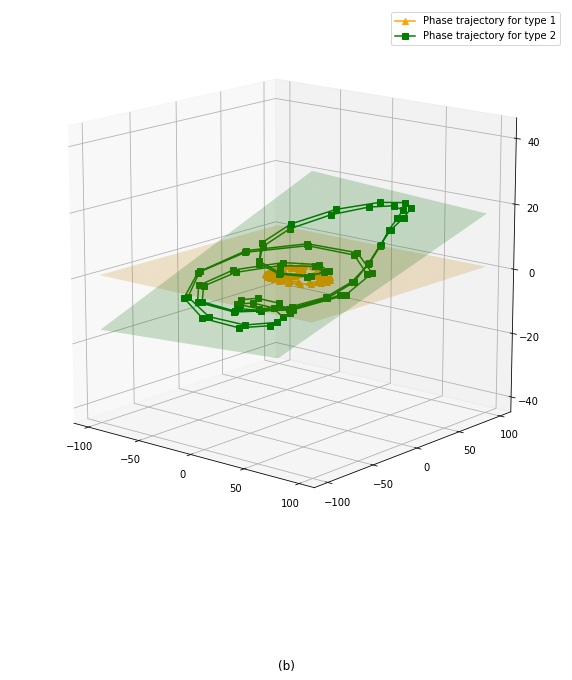

In [96]:
fig = plt.figure(figsize=(10,10));

marker = ['^', 's', 'v', 'D', 'P']
color = ['orange', 'green', 'red', 'yelow', 'blue']

gs = gridspec.GridSpec(1, 1)

ax = fig.add_subplot(gs[0], projection='3d');

xx, yy = np.meshgrid(range(-100, 100), range(-100, 100))
z_1 = (-normal_1[0] * xx - normal_1[1] * yy + point.dot(normal_1)) * 1./normal_1[2]
ax.plot_surface(xx, yy, z_1, alpha = 0.2,  color = color[0])
ax.plot(ress_a[:,0] , ress_a[:,1] , ress_a[:,2], "-", marker = marker[0],  color=color[0], label = 'Phase trajectory for type 1')
z_2 = (-normal_2[0] * xx - normal_2[1] * yy +point.dot(normal_2)) * 1./normal_2[2]
ax.plot_surface(xx, yy, z_2, alpha = 0.2,  color = color[1])
ax.plot(ress_b[:, 0] , ress_b[:, 1] , ress_b[:, 2], "-", marker = marker[1],  color=color[1], label = 'Phase trajectory for type 2')
ax.view_init(15, -50)
ax.legend(loc = 'best')
ax.xaxis.set_ticks(np.arange(-100, 101, 50))
ax.yaxis.set_ticks(np.arange(-100, 101, 50))
ax.zaxis.set_ticks(np.arange(-40, 41, 20))
ax.set_title('(b)', y=-0.25)

plt.subplots_adjust(wspace=0.05, hspace=0.2)
plt.show()

### Эксперимент по сегментации

In [97]:
data = pd.read_csv('https://raw.githubusercontent.com/andriygav/TimeSeriesClustering/master/code/RealData/2.csv')

In [98]:
T = 40
K = 2

X_test = data.values[100:1000, 2:3].reshape([1,-1,1])

List_of_x = np.arange(T, X_test[0].shape[0] - 2*T)

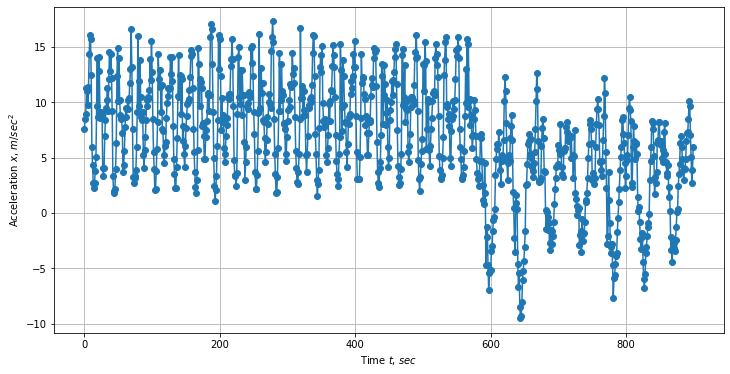

In [99]:
plt.figure(figsize=(12, 6))
_ = plt.plot(X_test[0], '-o')

plt.xlabel('Time $t$, $sec$')
plt.ylabel('Acceleration $x$, $m/sec^2$')
plt.grid()
plt.show()

In [100]:
phase_track = return_phase_track(X_test, T)

List_of_basis_vector, List_of_basis_vector_s, List_of_basis_vector_c = local_basis(phase_track, T = T)

M_pairwise = get_pairwise_matrix(List_of_basis_vector, List_of_basis_vector_s, List_of_basis_vector_c)


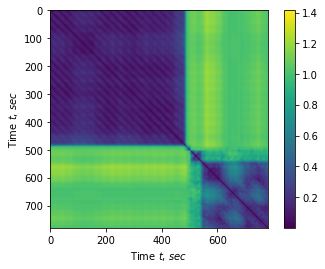

In [101]:
_ = plt.imshow(M_pairwise)

_ = plt.colorbar()

plt.xlabel('Time $t$, $sec$')
plt.ylabel('Time $t$, $sec$')
plt.show()

In [102]:
model = AgglomerativeClustering(n_clusters=K, affinity='precomputed', linkage='complete')

fitted = model.fit(M_pairwise)
prediction_vector = fitted.fit_predict(M_pairwise)


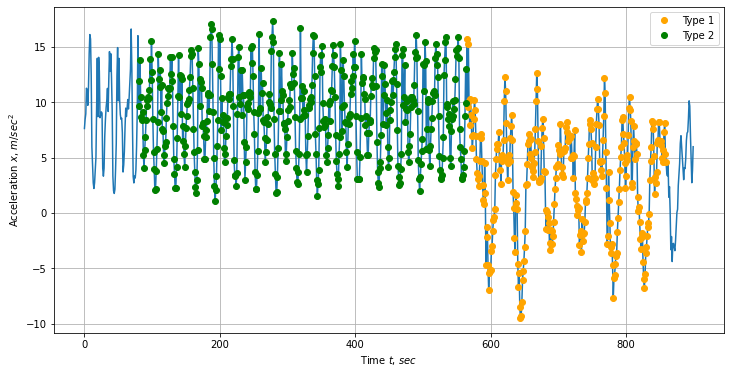

In [103]:
color = ['orange', 'green', 'red', 'yelow', 'blue']
plt.figure(figsize=(12, 6))
_ = plt.plot(X_test[0], '-')

for t in np.unique(prediction_vector):
    ind = np.where(prediction_vector == t)
    _ = plt.plot(List_of_x[ind]+T, X_test[0][2*T:X_test[0].shape[0]-T][ind], 'o', color = color[t], label = 'Type ' + str(t + 1))

plt.grid()
plt.legend(loc = 'best')
plt.xlabel('Time $t$, $sec$')
plt.ylabel('Acceleration $x$, $m/sec^2$')
plt.show()

In [104]:
List_of_All, List_of_point = segmentation(X_test[:, 2*T:X_test[0].shape[0]-T, :], prediction_vector, T)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:214: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:214: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


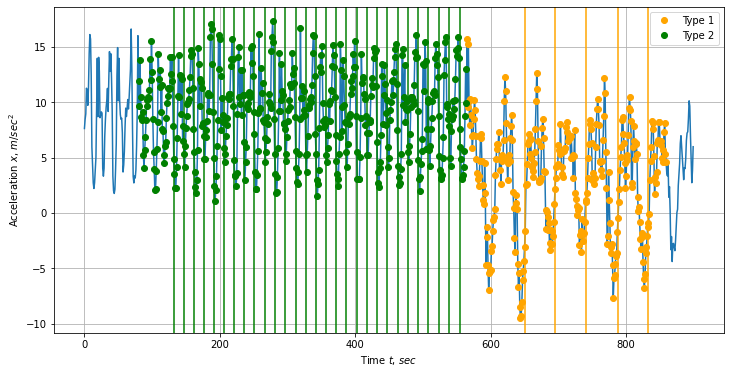

In [105]:
color = ['orange', 'green', 'red', 'yelow', 'blue']

plt.figure(figsize=(12, 6))
_ = plt.plot(X_test[0], '-')

for t in np.unique(prediction_vector):
#     _ = plt.plot(List_of_x[0] + T, 0, color = color[t], label = 'Type ' + str(t + 1))
    ind = List_of_point[t] + T
    for x in (List_of_x + T)[ind]:
        _ = plt.axvline(x = x, color = color[t])
        
    
for t in np.unique(prediction_vector):
    ind = np.where(prediction_vector == t)
    _ = plt.plot(List_of_x[ind]+T, X_test[0][2*T:X_test[0].shape[0]-T][ind], 'o', color = color[t], label = 'Type ' + str(t + 1))


plt.grid()
plt.legend(loc = 'best')
plt.xlabel('Time $t$, $sec$')
plt.ylabel('Acceleration $x$, $m/sec^2$')
plt.show()


In [106]:
index = 1

_, _, List_of_points_plus, List_of_points_minus, List_of_t_plus, List_of_t_minus, line_point, ress = List_of_All[index]

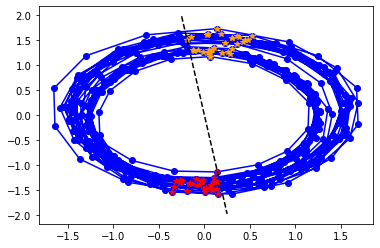

In [107]:
_ = plt.plot(ress[:, 0], ress[:, 1], '-o', color = 'blue')

for point in List_of_points_plus:
    _ = plt.plot(point[0], point[1], '*', color = 'orange')
for point in List_of_points_minus:
    _ = plt.plot(point[0], point[1], '*', color = 'red')

x_line = np.array([-0.25, 0.25])
k = line_point[1]/line_point[0]
y_line = k*x_line

_ = plt.plot(x_line, y_line, '--', color = 'black')

plt.show()